# FDA Project

Installing specialized packages: webdriver-manager, selenium, and wordcloud

In [ ]:
pip install webdriver-manager

In [ ]:
pip install selenium

In [ ]:
conda install -c https://conda.anaconda.org/conda-forge wordcloud

In [2]:
#Importing of useful packages
import pandas as pd
import re
import numpy as np
import json
import datetime
from bs4 import BeautifulSoup as bs
import requests
import re
import urllib
import time
import os
import string
import nltk
#nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, dates as mdates
%matplotlib inline
from wordcloud import WordCloud
from collections import Counter
%pylab inline
import statistics
from random import randrange


URL = "https://open.fda.gov/data/downloads/"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
#The FDA website does not load the downloadable files unless you scroll to that area of the page first
#Web-Scraping involves using the Selenium webdriver to open the site with Chrome, navigate to the
    #needed area, and hit the correct buttons at the correct time

from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import selenium.common.exceptions
from selenium import webdriver
import time

from selenium.webdriver.support.wait import WebDriverWait

options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.google.com")

driver.get(URL)
driver.maximize_window()

time.sleep(1)

#Get past the light screen
button1 = driver.find_element(By.CLASS_NAME, "button.bg-primary.clr-white")
button1.click()

time.sleep(1)
 
    #Scroll to the button for medical device events
element_link=WebDriverWait(driver, 10).until(EC.presence_of_element_located(
   (By.XPATH, '//*[@id="Medical Device Event"]')))

driver.execute_script("arguments[0].scrollIntoView(true)", element_link)

time.sleep(1)

#Click the medical device event button
button2 = driver.find_element(By.XPATH, '//*[@id="Medical Device Event"]/section/button')
button2.click()

time.sleep(1)

#Retrieve the html code now that it displays the links we need
html = driver.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
#print (html)

driver.close()

In [ ]:
#Snip HTML to just the portion in question
pattern = '1991(.*?)<li id="Medical Device PMA">'
substring = re.search(pattern, html).group(1)

In [ ]:
#Itemize links into array
import lxml.html

url_list = lxml.html.fromstring(substring)
url_list = url_list.xpath('//a/@href')
#print(newlist)

In [ ]:
start_year = 2011
end_year = 2021

year_list = list(range(start_year, end_year+1))

index_to_download = []

for meh in year_list:
    for bleh in range(0, len(url_list)):
        if str(meh) in url_list[bleh]:
            index_to_download.append(url_list.index(url_list[bleh]))

index_count = len(index_to_download)

In [ ]:
#Follow links in array to download/process ZIPs

#Specify Download Path
path = 'C:/Users/Allen/Documents/FDA'
#pathinverse = 'C:\Users\Allen\Documents\FDA'
import requests, zipfile
from io import BytesIO

#Filter Data by Project Code, use "All" to include all data
pcode = ["DYE","LWR","MIE","MWH","NPX","OHA","PAL","PAP"]
#pcode = ["All"]

#Run loop, opening JSONs
loopnumber = 0
datamain = ""
for snuh in index_to_download:
    print('Download ' + (str(loopnumber+1)) + " of " + (str(index_count)) + " started ")
    url = url_list[snuh]
    import requests, zipfile
    req = requests.get(url)
    print('Download ' + (str(loopnumber+1))+ " completed ")
    zipfile = zipfile.ZipFile(BytesIO(req.content))
    #filename = "FDA" + str(snuh+1)
    filename = "FDAdata.json"
    for i, f in enumerate(zipfile.filelist):
        f.filename = filename.format(i)
        zipfile.extract(f)
    print('File ' + (str(loopnumber+1))+ ' extracted')
    data = json.load(open(r'C:\Users\Allen\Documents\FDA\FDAdata.json'))
    data = data["results"]
    datamain = data
    if loopnumber == 0:
        print('Creating Dataframe with JSON ' + (str(loopnumber+1)))
        dfmain = pd.json_normalize(data,
                  record_path = "device",
                  meta = ["report_number","report_source_code","date_received","event_type","type_of_report","mdr_text"],
                  record_prefix = "_",
                  errors = "ignore")
        if pcode[0] != "All":
            dfmain = dfmain[dfmain._device_report_product_code.isin(pcode)]
        print('Dataframe Created')
    else:
        print('Appending Dataframe with JSON ' + (str(loopnumber+1)))
        dfnew = pd.json_normalize(data,
                  record_path = "device",
                  meta = ["report_number","report_source_code","date_received","event_type","type_of_report","mdr_text"],
                  record_prefix = "_",
                  errors = "ignore")
        if pcode[0] != "All":
            dfnew = dfnew[dfnew._device_report_product_code.isin(pcode)]
        dfmain = pd.concat([dfmain, dfnew])
        #dfmain.append(dfnew)
        print('JSON ' + (str(loopnumber+1)) + ' appended')
        
    os.remove(path + "/" + filename)
    loopnumber = loopnumber + 1
print("Dataframe ready")
dfmain.head()

In [ ]:
#dfmain.info()

#Keep only relevant columns
dfmain = dfmain[["_device_report_product_code","_brand_name","_generic_name","_manufacturer_d_name","type_of_report","report_number","report_source_code",
                 "date_received","event_type","mdr_text"]]

#Rename columns
dfmain.columns = ["product_code","brand_name","generic_name","manufacturer_name","type_of_report","report_number",
                        "report_source_code","date_received","event_type","mdr_text"]

#Update date column to date format
dfmain["date_received"] = pd.to_datetime(dfmain["date_received"])

#Remove brackets from type of report column
dfmain['type_of_report'] = dfmain['type_of_report'].str.join(', ')

#Update MDR Text to only show the text narrative items--also lowercase the text
newmdr = []
for crag in dfmain["mdr_text"]:
    newmdr.append(''.join(re.findall("'text': .+?}",str(crag))).translate(str.maketrans('', '', string.punctuation)).replace("text"," - ")[4:])

dfmain["mdr_text"] = [x.lower() for x in newmdr]
dfmain.head()

#dfmain.to_csv(r'data_test.csv', index = False)

In [ ]:
#dfmain = pd.read_csv("data_long.csv", encoding = 'unicode_escape')
#dfmain['mdr_text'] = dfmain['mdr_text'].map(str)

#Remove NA items
dfmain.fillna('', inplace=True)

#Prepare for lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

#Create function to tag words with what part of speech they are
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

#Create function to separate strings into words, assign parts of speech, and lemmatize accordingly
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

#Perform Lemmatization - this step can take some time
#If the dataset is particularly large at this point, it may be worth skipping this step
dfmain['mdr_text'] = dfmain['mdr_text'].apply(lambda x: lemmatize_sentence(x))

#Remove stop words
stop_words = set(stopwords.words('english'))

#Add additional common words into stopwords
stop_words.update(["investigation","still","progress","complete","supplemental","report","filed","device","returned","reported",
                  "-","due","failure","failed","may","ensure","assures","around","met","reports","number","per","dated","patient",
                  "conclusion","performed","year","years","therefore","submitted","information","received","upon","event",
                  "events","review","required","appropriate","monitored","monitor","basis","continue","monthly","trends","completion",
                  "additional","months","yet","without","history","regarding","cause","record","established","accordingly","procedure",
                  "provided","underwent","reason","evaluation","time","related","product","severed","post","return","made","also",
                  "andor","multiple","remains","determined","replacement","definitive","issues","however","clinical","factors",
                  "effects","release","identified","cannot","reviewed","would","including","available","issued","observation",
                  "common","action","regard","make","future","severe","issue","require","receive","month","submit","occur",
                  "factor","include","provide","remain","contribute","establish","relate","effect","replace","analysis","via",
                  "perform","subject","likely","although"])

dfmain = dfmain[dfmain['mdr_text'].notnull()]

dfmain['mdr_text'] = dfmain['mdr_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

dfmain.head()

In [ ]:
#dfmain = pd.read_csv("data.csv", encoding = 'unicode_escape')

no_dup = []

#Following function found from internet
def remove_duplicates(input):
 
    # split input string separated by space
    input = input.split(" ")
 
    # now create dictionary using counter method
    # which will have strings as key and their
    # frequencies as value
    UniqW = Counter(input)
 
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    return (s)

dfmain['mdr_text_nodup'] = dfmain['mdr_text'].apply(remove_duplicates)

dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)

dfmain.head()

In [ ]:
#Implement Word Cloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(dfmain["mdr_text_nodup"]))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('foo.png')
plt.show()

In [ ]:
#Create new date field with the days removed, for visualizations

#dfmain = pd.read_csv("data.csv", encoding = 'unicode_escape')
#dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)

dfmain["year"] = pd.to_datetime(dfmain["date_received"], format = '%Y-%m-%d').dt.year
dfmain["month"] = pd.to_datetime(dfmain["date_received"], format = '%Y-%m-%d').dt.month

dfmain["plaindate"] = pd.to_datetime(dfmain[['year', 'month']].assign(DAY=1))

dfmain = dfmain.drop(["year","month"], 1)

dfmain.head()

#dfmain.to_csv(r'data_organ.csv', index = False)

In [ ]:
dfmain.head()

In [ ]:
#Create new dataframe--list of unique words in data, separated by month
#dfmain = pd.read_csv("data_vent.csv", encoding = 'unicode_escape')
#dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)

dfword = pd.DataFrame()

#Create unique list of dates to be used in the for loop
datelist = dfmain["plaindate"].unique()

#Loop to create dataframe of unique words and the number of times they each appear
wordnumbers = []
for squid in datelist:
    wordnumbers = Counter(' '.join(map(lambda l: ''.join(l), dfmain.loc[dfmain["plaindate"] == squid]["mdr_text_nodup"])).split(" ")) 
    dftemp = pd.DataFrame.from_dict(wordnumbers, orient='index').reset_index()
    dftemp["Date"] = squid
    dfword = pd.concat([dfword, dftemp])
    
dfword.columns = ["word","counts","date"]

#Add column for % representation of each word during their time period
def percentcalc(countcol, datecol):
    perc = 0
    perc = countcol / len(dfmain[dfmain["plaindate"] == datecol])
    return perc

dfword["percent"] = dfword.apply(lambda x: percentcalc(x['counts'],x['date']), axis = 1)

dfword.head()
dfword.to_csv(r'word.csv', index = False)
dfmain.to_csv(r'main.csv', index = False)

In [16]:
dfmain = pd.read_csv("main.csv", encoding = 'unicode_escape')
dfmain['mdr_text_nodup'] = dfmain['mdr_text_nodup'].map(str)
dfword = pd.read_csv("word.csv", encoding = 'unicode_escape')

In [17]:
#Adding a new column to show the change from month to month--this was a challenge to do in a way that was not too
#time-intensive. Instead of trying to search for each previous month's value in the Dataframe and then performing the
#subtracting calculation, we sort the dataset by word and then by date, and go through each item checking if the previous
#line matches the word and the previous month. If these both match, the two are subtracted, but if not then the current
#value must be the "change". This way we only go through the dataframe a single time, instead of once for each row.

#I did attempt multiple searching algorithms but none of them could match the speed of this very dumbed-down approach.

#Begin by sorting the dataset and removing a leftover junk column
dfword = dfword.sort_values(["word","date"]).reset_index()
dfword.pop("index")

#Create a function to get the previous month off of a given string
def getlastmonth(dateinquestion):
    newdate = dateinquestion[5:7]
    newdate = int(newdate) - 1
    if newdate == 0:
        newdate = 12
    newdate = str(newdate)
    if len(newdate) == 1:
        newdate = "0" + newdate
    newdate = dateinquestion[0:4] + "-" + newdate + dateinquestion[7:10]
    if newdate[5:7] == "12":
        newmonth = str(int(newdate[0:4]) - 1)
        newdate = newmonth + "-" +  newdate[5:7] + dateinquestion[7:10]
    return newdate

#Create a function to check if the previous row in the dataset is the actual previous month for the word in question,
#and then perform the subtraction if necessary to arrive at the change value
def previous_values(indexitem):
    if indexitem > 0:
        if (dfword["date"][indexitem-1] == getlastmonth(dfword["date"][indexitem])) & (dfword["word"][indexitem-1] == dfword["word"][indexitem]):
            return (dfword["counts"][indexitem] - dfword["counts"][indexitem-1])
        else:
            return dfword["counts"][indexitem]
    else:
        return dfword["counts"][indexitem]

#Create the new column with the change value
dfword["change"] = dfword.apply(lambda x: previous_values(x.name), axis = 1)

In [18]:
dfword.to_csv(r'wordheartchange2.csv', index = False)

In [19]:
# Create a dataset with each month and and the number of reports for those months
datelist = dfmain["plaindate"].unique()

dfline = pd.DataFrame()
dfline["date"] = datelist
dfline["counts"] = dfline["date"].apply(lambda x: len(dfmain[dfmain["plaindate"] == x]))

#Set date column to the datetime type, and sort by date
dfline["date"] = pd.to_datetime(dfline["date"])
dfline = dfline.sort_values(by="date")

filter_date_start = "2010-01-01"
filter_date_end = "2022-12-31"

mask = (dfline['date'] >= filter_date_start) & (dfline['date'] <= filter_date_end)
dfline = dfline.loc[mask]


dfline.head()

,date,counts
1,2011-01-01,87
2,2011-02-01,119
0,2011-03-01,153
3,2011-04-01,152
5,2011-05-01,193


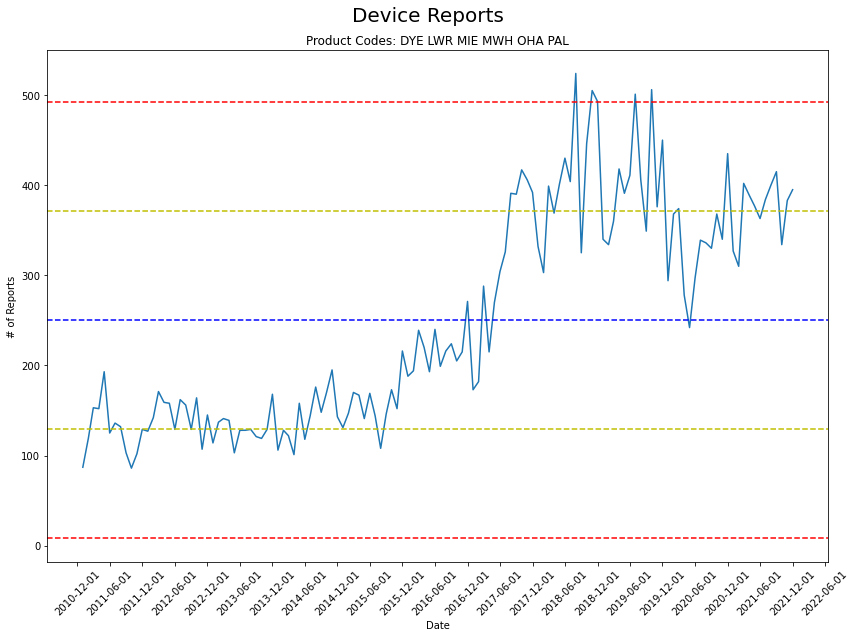

In [97]:
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

if len(dfline["date"].unique()) > 12:
    locator = mdates.MonthLocator(interval = 6)
else:
    locator = mdates.MonthLocator(interval = 1)
ax.xaxis.set_major_locator(locator)
plt.plot(dfline["date"], dfline["counts"])

plt.suptitle("Device Reports", fontsize = 20)
plt.title("Product Codes: " + " ".join(dfmain["product_code"].unique()))
plt.xlabel("Date")
plt.ylabel("# of Reports")
plt.xticks(rotation = 45)
plt.axhline(y=dfline["counts"].mean(), color='b', linestyle='--')
plt.axhline(y=dfline["counts"].mean()+dfline["counts"].std(), color='y', linestyle='--')
plt.axhline(y=dfline["counts"].mean()+dfline["counts"].std()*2, color='r', linestyle='--')
plt.axhline(y=dfline["counts"].mean()-dfline["counts"].std(), color='y', linestyle='--')
plt.axhline(y=dfline["counts"].mean()-dfline["counts"].std()*2, color='r', linestyle='--')

plt.show()

In [100]:
# Create a linechart to show the change of a word over time
#Start by creating a new dataframe with the word count information for just the word in question

lineword = "medtronic"
lineyearstart = 2011
lineyearend = 2021

lineyearstart = str(lineyearstart) + "-01-01"
lineyearend = str(lineyearend) + "-12-31"

linedaterange = pd.date_range(lineyearstart,lineyearend, 
              freq='MS').strftime("%Y-%m-%d").tolist()

dfwordline = pd.DataFrame()
dfwordline["date"] = linedaterange

dfwordline["word"] = lineword

def get_word_count(wordinquestion, dateinquestion):
    try:
        countneeded = dfword.loc[(dfword['word'] == wordinquestion) & (dfword['date'] == dateinquestion)]["counts"].iat[0]
    except IndexError:
        countneeded = 0
    return countneeded

dfwordline["counts"] = dfwordline["date"].apply(lambda x: get_word_count(lineword, x))

dfwordline.head()

,date,word,counts
0,2011-01-01,medtronic,9
1,2011-02-01,medtronic,13
2,2011-03-01,medtronic,7
3,2011-04-01,medtronic,17
4,2011-05-01,medtronic,4


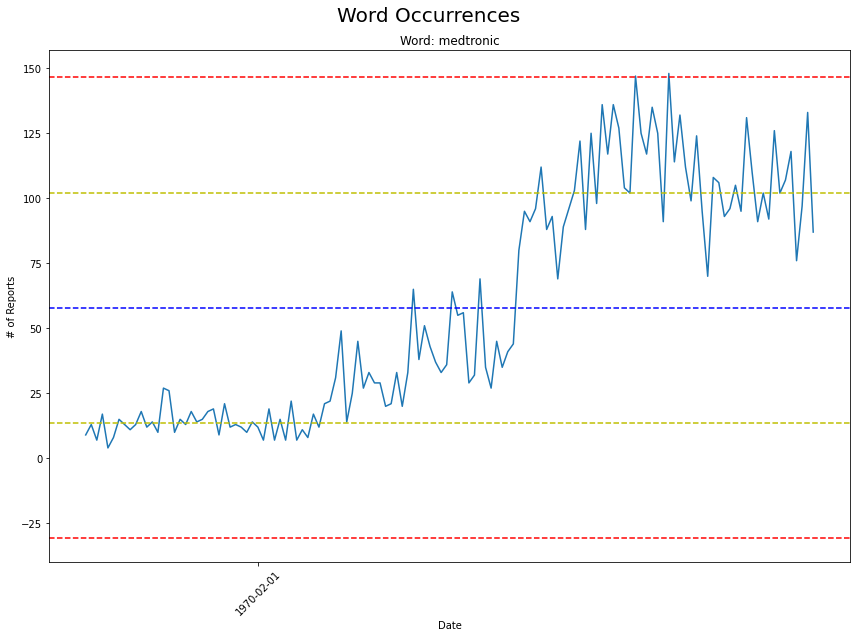

In [101]:
#Create line chart for individual word
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

ax = plt.gca()

formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

if len(dfwordline["date"].unique()) > 12:
    locator = mdates.MonthLocator(interval = 6)
else:
    locator = mdates.MonthLocator(interval = 1)
ax.xaxis.set_major_locator(locator)
plt.plot(dfwordline["date"], dfwordline["counts"])

plt.suptitle("Word Occurrences", fontsize = 20)
plt.title("Word: " + " ".join(dfwordline["word"].unique()))
plt.xlabel("Date")
plt.ylabel("# of Reports")
plt.xticks(rotation = 45)
plt.axhline(y=dfwordline["counts"].mean(), color='b', linestyle='--')
plt.axhline(y=dfwordline["counts"].mean()+dfwordline["counts"].std(), color='y', linestyle='--')
plt.axhline(y=dfwordline["counts"].mean()+dfwordline["counts"].std()*2, color='r', linestyle='--')
plt.axhline(y=dfwordline["counts"].mean()-dfwordline["counts"].std(), color='y', linestyle='--')
plt.axhline(y=dfwordline["counts"].mean()-dfwordline["counts"].std()*2, color='r', linestyle='--')

plt.show()

In [81]:
dfword.loc[(dfword['word'] == "confirm") & (dfword['date'] == "2011-01-01")]["counts"].iat[0]

#dfwordline["counts"] = dfwordline["date"].apply(lambda x:
#                                                dfword.loc[(dfword['word'] == lineword) & (dfword['date'] == x)]["counts"].iat[0])

17

In [72]:
dfword[dfword["word"] == "confirm"]

,word,counts,date,percent,change
69136,confirm,17,2011-01-01,0.195402,17
69137,confirm,16,2011-02-01,0.134454,-1
69138,confirm,34,2011-03-01,0.222222,18
69139,confirm,26,2011-04-01,0.171053,-8
69140,confirm,96,2011-05-01,0.497409,70
...,...,...,...,...,...
69263,confirm,40,2021-08-01,0.100000,-3
69264,confirm,59,2021-09-01,0.142169,19
69265,confirm,27,2021-10-01,0.080838,-32
69266,confirm,18,2021-11-01,0.046997,-9
